# Modeling 3
* Aggregate `transcript_id`, `transcript_position`, `nucleotides` using mean.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import \
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import \
    StratifiedKFold, GridSearchCV
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, precision_recall_curve, \
    roc_auc_score, average_precision_score, \
    confusion_matrix, classification_report
from xgboost import XGBClassifier 
from math import floor

%matplotlib inline
plt.style.use('default')
warnings.filterwarnings("ignore")

DATA_DIR = "../data"  # save data locally for faster read / write
MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models') # models' size not as big as data, save in s3 for everyone 

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "df2_no_duplicates.csv"))

In [3]:
df.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,gene_id,label
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,ENSG00000004059,0


In [4]:
df.dtypes

transcript_id           object
transcript_position      int64
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [5]:
# designate data types
# df['label'] = df['label'].astype(str)
df['transcript_position'] = df['transcript_position'].astype(str)

In [6]:
df.dtypes

transcript_id           object
transcript_position     object
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [7]:
# groupby and agg using mean 
df2 = df.groupby(by = ['transcript_id', 'transcript_position', 'nucleotides']).mean()
df2.reset_index(inplace=True)
df2.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,label
0,ENST00000000233,244,AAGACCA,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,0.0
1,ENST00000000233,261,CAAACTG,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,0.0
2,ENST00000000233,316,GAAACAG,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,0.0
3,ENST00000000233,332,AGAACAT,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000,0.0
4,ENST00000000233,368,AGGACAA,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,0.0


In [8]:
df2.shape

(121838, 13)

## Train test split

In [9]:
X = df2[['0', '1', '2', '3', '4', '5', '6', '7', '8']]
y = df2['label']

In [10]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Collect models and results

In [11]:
models = []
roc_aucs = []
pr_aucs = []
precisions = []
recalls = []
f1s = []
roc_curves = []
pr_curves = []

## Naive Bayes

In [12]:
# %%time

# model = GaussianNB()
# model.fit(Xtr, ytr)

CPU times: user 26.2 ms, sys: 3.57 ms, total: 29.7 ms
Wall time: 29 ms


GaussianNB()

In [13]:
# with open(os.path.join(MODEL_DIR, 'nb3.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [14]:
with open(os.path.join(MODEL_DIR, 'nb3.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

GaussianNB()


In [15]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [16]:
models.append('nb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## kNN

In [18]:
# %%time
# model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
# model.fit(Xtr, ytr)

CPU times: user 187 ms, sys: 6.92 ms, total: 194 ms
Wall time: 193 ms


KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [19]:
# with open(os.path.join(MODEL_DIR, 'knn2.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [20]:
with open(os.path.join(MODEL_DIR, 'knn2.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


In [21]:
# yhat_probs = model.predict_proba(Xte)
# yhat = model.predict(Xte)
# yhat1_probs = yhat_probs[:, 1]

In [22]:
# with open(os.path.join(MODEL_DIR, 'knn2_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'knn2_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [23]:
with open(os.path.join(MODEL_DIR, 'knn2_yhat_probs.pickle'), 'rb') as f:
    yhat_probs = pickle.load(f)
    
with open(os.path.join(MODEL_DIR, 'knn2_yhat.pickle'), 'rb') as f:
    yhat = pickle.load(f)
    
yhat1_probs = yhat_probs[:, 1]

In [24]:
# %%time
# # selecting the classifier
# knn = KNeighborsClassifier(n_jobs=-1)

# # selecting hyperparameter tuning
# param = {"n_neighbors": np.arange(3, 6)}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(knn, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [25]:
models.append('knn')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## SVM (linear kernel)

In [26]:
# %%time
# model = LinearSVC(random_state=42)
# model.fit(Xtr, ytr)

CPU times: user 20 s, sys: 43.2 ms, total: 20.1 s
Wall time: 20.1 s


LinearSVC(random_state=42)

In [27]:
# with open(os.path.join(MODEL_DIR, 'lsvc2.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [28]:
with open(os.path.join(MODEL_DIR, 'lsvc2.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

LinearSVC(random_state=42)


In [29]:
# yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
# yhat1_probs = yhat_probs[:, 1]

In [30]:
# # selecting the classifier
# lsvc = LinearSVC()

# # selecting hyperparameter tuning
# param = {"C": np.exp(np.linspace(start=np.log(0.001), stop=np.log(10000), num=5))}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(lsvc, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [31]:
models.append('lsvc')
roc_aucs.append(roc_auc_score(yte, yhat))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat))
pr_curves.append(precision_recall_curve(yte, yhat))

## LDA

In [32]:
# %%time
# model = LinearDiscriminantAnalysis(solver='svd')
# model.fit(Xtr, ytr)

CPU times: user 190 ms, sys: 61.6 ms, total: 251 ms
Wall time: 155 ms


LinearDiscriminantAnalysis()

In [33]:
# with open(os.path.join(MODEL_DIR, 'lda2.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [34]:
with open(os.path.join(MODEL_DIR, 'lda2.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

LinearDiscriminantAnalysis()


In [35]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [36]:
models.append('lda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## QDA

In [37]:
# %%time
# model = QuadraticDiscriminantAnalysis()
# model.fit(Xtr, ytr)

CPU times: user 200 ms, sys: 161 ms, total: 362 ms
Wall time: 90.4 ms


QuadraticDiscriminantAnalysis()

In [38]:
# with open(os.path.join(MODEL_DIR, 'qda2.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [39]:
with open(os.path.join(MODEL_DIR, 'qda2.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

QuadraticDiscriminantAnalysis()


In [40]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [41]:
models.append('qda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost

In [42]:
from collections import Counter

# count examples in each class
count_label = Counter(ytr)
# estimate scale_pos_weight value
estimate = count_label[0] / count_label[1]
print('Estimate: %.3f' % estimate)

Estimate: 21.253


In [43]:
from math import ceil

model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight = ceil(estimate),
    max_delta_step=1,
    seed=42,
    verbosity=1
)

In [44]:
model.fit(Xtr, ytr)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
# model.save_model(os.path.join(MODEL_DIR, 'xgb3.model'))

In [46]:
# model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb3.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)


In [47]:
# xgb.plot_tree(model, num_trees=2)
# xgb.to_graphviz(model, num_trees=2)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

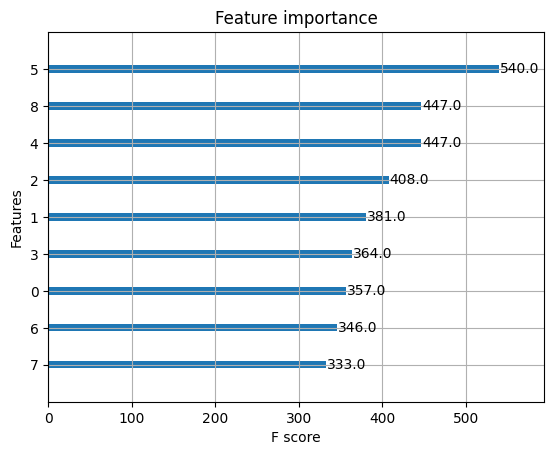

In [48]:
xgb.plot_importance(model)

In [49]:
yhat_probs = model.predict_proba(Xte, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [50]:
# with open(os.path.join(MODEL_DIR, 'xgb3_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'xgb3_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [51]:
models.append('xgb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## Evaluate models

nb: ROC AUC = 0.728
nb: PR AUC = 0.045
nb: Precision = 0.250
nb: Recall = 0.001
nb: F1 = 0.002
knn: ROC AUC = 0.756
knn: PR AUC = 0.179
knn: Precision = 0.513
knn: Recall = 0.287
knn: F1 = 0.368
lsvc: ROC AUC = 0.500
lsvc: PR AUC = 0.045
lsvc: Precision = 0.000
lsvc: Recall = 0.000
lsvc: F1 = 0.000
lda: ROC AUC = 0.706
lda: PR AUC = 0.045
lda: Precision = 0.000
lda: Recall = 0.000
lda: F1 = 0.000
qda: ROC AUC = 0.781
qda: PR AUC = 0.047
qda: Precision = 0.146
qda: Recall = 0.022
qda: F1 = 0.038
xgb: ROC AUC = 0.875
xgb: PR AUC = 0.161
xgb: Precision = 0.210
xgb: Recall = 0.704
xgb: F1 = 0.324


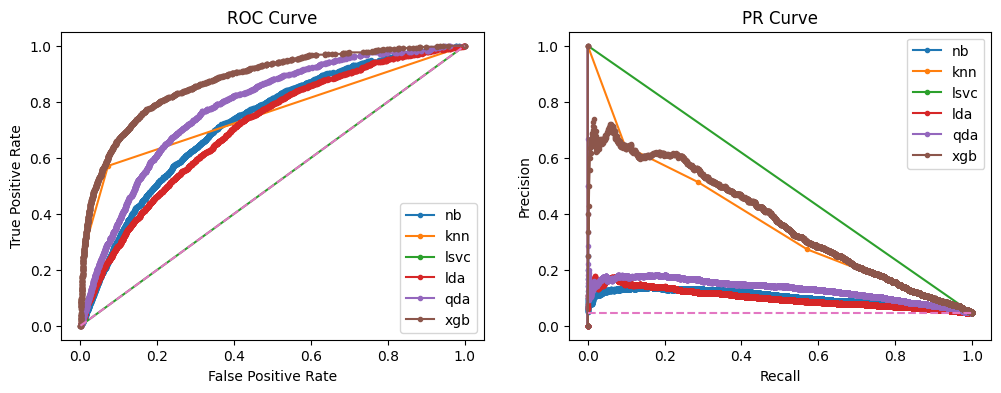

In [52]:
plt.figure(figsize=(12, 4))
random_yhat_probs = np.zeros(len(yte))
random_fpr, random_tpr, _ = roc_curve(yte, random_yhat_probs)

# relevant metrics
# roc_auc_score(yte, yhat1_probs)
# average_precision_score(yte, yhat)
# precision_score(yte, yhat)
# recall_score(yte, yhat)
# f1_score(yte, yhat)
# roc_curve(yte, yhat1_probs)
# precision_recall_curve(yte, yhat1_probs)

for _model, _roc_auc, _pr_auc, _precision, _recall, _f1, _roc_curve, _pr_curve in zip(models, roc_aucs, pr_aucs, precisions, recalls, f1s, roc_curves, pr_curves):
    print(f'{_model}: ROC AUC = {_roc_auc:.3f}')
    print(f'{_model}: PR AUC = {_pr_auc:.3f}')
    print(f'{_model}: Precision = {_precision:.3f}')
    print(f'{_model}: Recall = {_recall:.3f}')
    print(f'{_model}: F1 = {_f1:.3f}')


    # ROC
    fpr, tpr, _ = _roc_curve

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=_model)

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


    # PR
    precision, recall, _ = _pr_curve

    plt.subplot(1, 2, 2)
    no_skill = len(yte[yte==1]) / len(yte)
    plt.plot(recall, precision, marker='.', label=_model)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

plt.subplot(1, 2, 1)
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
plt.show()